Group Name: Anonymous

Group members:

- Shuang Jie Zhu 33432457

- Kaicheng Huang 34253572

- Yuhang Peng 34278818

- Jingmin Zhu 34265597 

# FIT5226 Project

## Stage 1 - Tabular Q-Learning
***

### 1. Imports

Two libraries (`numpy`, `matplotlib`) and one module (`random`) are utilised for stage 1 of the project.

In [1]:
# Use the TkAgg backend in matplotlib to display both plots and animations.
import matplotlib
matplotlib.use('TkAgg')

In [2]:
# Importing the required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

***

### 2. Environment Setup

##### **Environment description**

A single agent operates within a grid environment where the task is to pick up the item at a randomly determined location $A$ and deliver it to a fixed target location $B$. The grid world is defined as a square grid of size $n \times n$, with $n$ being a parameterisable dimension with a default value of 5. The agent begins at a random location on the grid and must navigate to the item location $A$, pick it up and then transport it to the target location $B$, which is fixed at the bottom right corner of the grid with coordinates $(n-1, n-1)$.

##### **Assumptions for initial agent, item and target locations**
- Initial item location cannot be the same as initial agent location.
- Initial item location cannot be the same as target location.

##### **State space**

The state space for the agent consists of the following components:

1. **Agent location**: The current position of the agent on the grid, which is represented as a tuple of coordinates $(y_{agent},x_{agent})$.
2. **Item location**: The location of the item on the grid, which is represented as a tuple of coordinates $(y_{item},x_{item})$.
3. **Item possession status**: A boolean value indicates whether the agent has picked up the item, which is represent by a boolean variable $has\_item$.

Thus, the complete state of the environment can be represented as a tuple $\left((y_{agent},x_{agent}), (y_{item},x_{item}), has\_item\right)$.

##### **Action space**

The agent has four actions that it can execute:
- **Move north**: The agent attempts to move one cell upwards on the grid.
- **Move south**: The agent attempts to move one cell downwards on the grid.
- **Move west**: The agent attempts to move one cell to the left on the grid.
- **Move east**: The agent attempts to move one cell to the right on the grid.

These actions are executed with boundary checks to ensure that the agent does not move outside the grid.

##### **Reward structure**

In reinforcement learning, the reward structure is designed to encourage the agent to complete the task of picking up the item at location $A$ and delivering it to location $B$ efficiently. The reward structure is designed as follows:

- **Step penalty**: The agent receives a penalty of -1 for each step it takes. This encourages the agent to complete the task in as few steps as possible.
- **Hit-wall penalty**: The agent receives a penalty of -5 for each time it hits a wall. This encourages the agent not to get out the grid.
- **Item pickup**: When the agent successfully reaches the item location $A$ and picks up the item, it continues to receive the step penalty of -1. No additional reward is given for picking up the item as it is part of the task. A small reward can be given to the agent in a practical application, which is not applied in the current setting.
- **Task completion**: The agent receives a reward of +100 upon successfully deliverying the item to the target location $B$, which indicates the completion of the task.

The environment and reward structure are set up to reinforce the agent's learning of an optimal policy that minimise the number of steps taken to complete the task. The agent need balance between exploring the grid to find the item and exploiting its knowledge to arrive the target location as quickly as possible once the item being picked up.

The environment is implemented in Python as a class `GridWorld`, which supports grids of arbitrary size. The grid size and target location are parameterised, allowing the environment to be easily adapted to different scenarios. The movements of the agent are controlled through the `step` function, which updates the environment based on the action taken and returns the new state, the reward for the action and a boolean value indicating whether the task is completed. The environment also includes a `reset` function, which randomises the agent and item location, allowing the agent to start the task from different initial locations, promoting generalisation during its learning process.

This setup provides a clear and efficient framework for the agent to learn the task of picking up and transporting an item within a grid world environment. The reward structure is designed to be simple yet effective, encouraging the agent to learn an optimal path from any starting position to the target location via the item location. The flexibility of the design of the environment allows for easy adjustments to grid size and task complexity, making it a robust foundation for further experimentation and learning in reinforcement learning tasks.

In [3]:
# GridWorld class defines the grid world environment
class GridWorld:
    # Define the grid world environment with default size 5x5 and target location at the bottom-right corner
    # The agent and item locations are randomly initialised unless given_location is set to True (this is for testing phase)
    def __init__(self, size=5, target_location=None, initial_agent_location=(0,0), initial_item_location=(0,1), given_location=False):
        self.size = size
        self.target_location = target_location if target_location else (size-1, size-1)
        # If the agent and item locations are given, then use them, otherwise randomly initialise them
        if given_location == False:
            self.reset()
        else:
            self.agent_location = initial_agent_location
            self.item_location = initial_item_location
            self.has_item = False

    # Reset the grid world environment to the initial state
    def reset(self):
        # Randomly initialise the agnet position in the grid and agent location can be the same as the target location
        self.agent_location = self._random_position()
        
        # Randomly initialise the item position in the grid and ensure it is not at the target location or agent location
        self.item_location = self._random_position()
        while self.item_location == self.target_location or self.item_location == self.agent_location:
            self.item_location = self._random_position()
        
        # The agent doesn't have the item initially
        self.has_item = False

        # Return the initial state
        return self._get_state()

    # Generate a random position in the grid
    def _random_position(self):
        return (random.randint(0, self.size-1), random.randint(0, self.size-1))

    # Get the current state of (agent_location, item_location, has_item) as a tuple
    def _get_state(self):
        return (self.agent_location, self.item_location, self.has_item)

    # Execute an action, then return the next state, reward, and whether the task is finished.
    def step(self, action):
        # Get the current agent location (y, x)
        y, x = self.agent_location

        # Define the action to move the agent in the four directions
        if action == 'north':
            new_y, new_x = y - 1, x
        elif action == 'south':
            new_y, new_x = y + 1, x
        elif action == 'west':
            new_y, new_x = y, x - 1
        elif action == 'east':
            new_y, new_x = y, x + 1
        else:
            raise ValueError("Invalid action!")

         # Move the agent to the new location only if it is within the grid
        if 0 <= new_x < self.size and 0 <= new_y < self.size:
            # Update the agent location to the new location (new_y, new_x)
            self.agent_location = (new_y, new_x)
            wall_hit = False
        # Else keep the agent in place and label it as hitting the wall
        else:
            wall_hit = True

        # If the agent reached the item location, pick up the item
        if not self.has_item and self.agent_location == self.item_location:
            reward = -1
            self.has_item = True
        # Else if the agent reached the target location with the item, reward the agent with +100 and finish the task 
        elif self.has_item and self.agent_location == self.target_location:
            reward = 100
            done = True
            return self._get_state(), reward, done
        # Else check if the agent hit the wall
        elif wall_hit:
            reward = -5       # Small penalty for hitting the wall
            wall_hit = False  # Reset wall_hit after applying the penalty
        # Else a step penalty of -1 is given
        else:
            reward = -1
        
        done = False  # Task is not finished yet
        return self._get_state(), reward, done

***

### 3. Q-learning Algorithm

In this task, a table-based Q-learning algorithm is implemented in a Python class `QLearningAgent` for an agent to complete a transport task in a grid world environment. Q-learning is an off-policy reinforcement learning algorithm that aims to find the optimal action-selection policy by learning the action-value function $Q(S,A)$, where $S$ and $A$ represent state and action, respectively. The action-value function estimates the expected cumulative reward for taking an action $A$ in state $S$ and following the optimal policy thereafter. The key idea of the algorithm is to iteratively update the Q-value based on the agent's experiences regarding the environment.

##### **Key components**

1. **Initialisation**:

The Q-value are stored in a table (`self.q_table`), which is implemented as a Python dictionary where the keys are state-action pairs and the values are the corresponding Q-values. The agent is initialised with parameters for the learning rate (lr), discount factor (gamma), exploration rate (epsilon), exploration decay rate (epsilon_decay) and minimum exploration rate (min_epsilon).

2. **Q-value retrieval**:

The function `get_q_value` retrieves the Q-value for a given state-action pair. If the Q-value does not exist in the table, it is initialised to zero to ensure that all posiible state-action pairs are accounted for during the learning process.

3. **Action selection**:

The function `choose_action` employs an $\epsilon$-greedy policy for th agent to select actions. With probability $\epsilon$, the agent explores by choosing a random action. Otherwise, it exploits its current knowledge by selecting the action with the highest Q-value with probability $1-\epsilon$. The Q-value for all possible actions in the current state are evaluated and the action(s) with the maximum Q-value are identified. If multiple actions have the same maximum Q-values, one is selected randomly to avoid bias and promote exploration.

4. **Q-value update**:

The Q-value for a given state-action pair is updated using the function `update_q_value` based on the reward received and the maximum Q-value of the subsequent state (if it is not terminal). The standard Q-learning update rule is adopted, which can be written as:

\begin{equation}
 Q(S,A) \leftarrow Q(S,A) + \alpha \left( R + \gamma \max\limits_{A'} Q(S', A') - Q(S, A)  \right)，
\end{equation}

where $\alpha$ is the learning rate, determining how much new knowledge overrides the old one. The variable $R$ is the reward received after take action $A$ in state $S$. The variable $\gamma$ is the discount factor, which controls the importance of future rewards. The term $\max\limits_{A'} Q(S', A')$ is the maximum Q-value for the next state $S'$, representing the best future value.

It is important to point out that the Q-value is updated solely based on the immediate reward $R$ if the episode ends ($done$ is $Ture$), since there are no future states to consider.

5. **Exploration rate decay**:

The function `decay_exploration` models the exploration rate $\epsilon$ is decayed multiplicateively by a factor (epsilon_decay) after each episode. This gradual reduction in exploration allows the agent to transition from exploration to exploitation as it learns more about the environment. The exploration rate is calmped to a minimum value (min_epsilon) to ensure that the agent retains some level of exploration throughout the learning process.

The implemented Q-learning algorithm is designed to enable the agent to efficiently learn an optimal policy for the transport task in the grid world environment. By balancing exploration and exploitation through the $\epsilon$-greedy policy and using the Q-value updates to iteratively improve its knowledge, the agent can learn to complete the task with minimal steps.

In [4]:
# QLearningAgent defines the agent Q-learning algorithm
class QLearningAgent:
    # Define the Q-learning algorithm for the agent with default parameters
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, exploration_decay=0.95, min_exploration_rate=0.01):
        self.actions = actions  # Possible actions
        self.lr = learning_rate  # Learning rate
        self.gamma = discount_factor  # Discount factor
        self.epsilon = exploration_rate  # Exploration rate (epsilon)
        self.epsilon_decay = exploration_decay  # Exploration decay rate
        self.min_epsilon = min_exploration_rate  # Minimum exploration rate value
        self.q_table = {}  # Initialise the Q-table as a dictionary
    
    # Get the Q-value for a state-action pair 
    def get_q_value(self, state, action):
        # Initialise Q-value to 0.0 if it doesn't exist.
        if (state, action) not in self.q_table:
            self.q_table[(state, action)] = 0.0
        return self.q_table[(state, action)]
    
    # Choose an action based on the epsilon-greedy policy
    def choose_action(self, state):
        # Exploration with probability epsilon
        if np.random.rand() < self.epsilon:
            return random.choice(self.actions)
        # Else exploitation with probability 1 - epsilon
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            max_q_value = max(q_values)
            best_actions = [action for action, q_value in zip(self.actions, q_values) if q_value == max_q_value]
            return random.choice(best_actions) # Randomly choose one of the best actions to expliot

    # Update the Q-value for a state-action pair based on the reward and next state
    def update_q_value(self, state, action, reward, next_state, done):
        current_q_value = self.get_q_value(state, action)
        # If the next state is terminal (done), the Q-value is only based on the reward
        if done:
            td_target = reward
        # Else update the Q-value based on the reward and the maximum Q-value of the next state
        else:
            next_q_values = [self.get_q_value(next_state, next_action) for next_action in self.actions]
            td_target = reward + self.gamma * max(next_q_values)
        
        td_error = td_target - current_q_value
        self.q_table[(state, action)] = current_q_value + self.lr * td_error

    # Decay the exploration rate after each episode for the purpose of exploration-exploitation trade-off
    def decay_exploration(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

***

### 4. Training Phase

The training process is implemented in the function `train_agent`, which trians the agent over a default of 1000 episodes. 

##### **Key components**

1. **Episode initialisation**:

At the start of each episode, the environment is reset using the `env.reset()` method, which randomises the initial agent location and the initial item location. The initial state of the environment is returned. A boolean variable $done$ is initialised to $False$, indicating that the episode is not yet finished.

2. **Agent-environment interaction**:

Within each episode, the agent interacts with the environment until it successfully completes the task by delivery the item to the target location  $B$. The agent selects an action using the `choose_action(state)` method, which follows an $\epsilon$-greedy policy to balance exploration and exploitation. The selected action is executed in the environment using `env.step(action)`, which returns the next state, the reward received, and whether the episode is done.

3. **Q-value update**:

After executing an action, the agent updates the Q-value for the state-action pair using the `update_q_value(state, action, reward, next_state, done)` method. This update is based on the Q-learning update rule as shown in Equation (1). The state is then updated to the new state returned by the environment and the loop continues until the task is completed.

4. **Exploration rate decay**:
After each episode, the agent’s exploration rate  $\epsilon$  is decayed using the `decay_exploration()` method. This gradual reduction in exploration allows the agent to increasingly exploit its learned policy as it gains more experience.

5. **Progress monitoring**:

To monitor the training progress, the code prints out a message every 1000 episodes, indicating the completion of that episode and the current value of  $\epsilon$ to help in tracking how the exploration rate evolves over time and ensure that the training process is proceeding as expected.

6. **Post-training insights (Optional)**:

After training, optional code snippets are provided to print the learned Q-values for each state-action pair and the size of the Q-table. These insights can be helpful in understanding the extent of the agent’s learning and the complexity of the learned policy.

In [5]:
# Train the agent with a default of 1000 episodes
def train_agent(agent, env, episodes=1000):
    for episode in range(episodes):
        # Reset the environment for each new episode
        state = env.reset()
        done = False
    
        # Agent continue until the task is finished
        while not done:
            action = agent.choose_action(state)  # Agent chooses an action
            next_state, reward, done = env.step(action)  # Execute the action in the environment
        
            # Update the Q-value based on the reward received and the new state
            agent.update_q_value(state, action, reward, next_state, done)
        
            # Update to the next state
            state = next_state

        # Decay the exploration rate after each episode
        agent.decay_exploration()

        # Print the progress every 1000 episodes
        # if (episode + 1) % 1000 == 0:
        #     print(f'Episode {episode + 1}/{episodes} completed. Epsilon: {agent.epsilon:.3f}')

    # Print the learned Q-values
    # for state, actions in agent.q_table.items():
    #    print(f'State: {state}, Q-values: {actions}')

    # Print the size of the Q-table
    # print(f"Q-Table Size: {len(agent.q_table)} entries")

***

### 5. Evaluation Phase


#### **Introduction**
In this project, our goal is to implement a tabular Q-learning algorithm to enable an agent to effectively complete a specified task in a grid world environment. The agent's task is to start from a random position, pick up an item located at point A, and deliver it to point B. To evaluate the agent's learning and generalization abilities, we designed two tests: the first test assesses the model's performance with different numbers of training episodes, the second test evaluates the performance of a model trained extensively across all possible initial states.

Our objectives in conducting these tests are as follows:

##### **1. Verifying the model's learning ability**
- **Objective**: Through the first test, we can verify the model's learning ability under different training conditions. Theoretically, as the number of training episodes increases, the model should be able to better learn the optimal strategy for completing the task.

- **Expected outcome**: By analysing the success rate, average steps, average reward, and deviation from the optimal strategy, we can verify whether increasing the training episodes indeed leads to improved performance. If the test results show improvement in these metrics as the number of training episodes increases, it indicates that the model's learning ability has been enhanced.

##### **2. Verifying the model's generalisation ability**
- **Objective**: Through the second test, we can verify the performance of the trained model under different initial conditions.

- **Expected outcome**: If the test results show that the model maintains a high success rate and low average steps and deviation under all possible initial states, it indicates that the model has strong generalisation ability. This means that the model not only performs well under specific training conditions but can also effectively complete tasks in varying environments.

In [6]:
# Function to calculate the Manhattan distance between two points, which is used to calculate the optimal steps
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Function to test the agent in the environment for a certain number of episodes with default 100 random episodes.
# The stepa_verbose parameter is used to control printing the details of each step in the episode.
def test_agent(agent, env, episodes=100, step_verbose=True):
    # Initialise the metrics to calculate the overall performance
    success_count = 0.0
    total_steps = 0.0
    total_reward = 0.0
    total_deviation = 0.0
    total_deviation_rate = 0.0

    # Test the agent for the specified number of episodes
    for episode in range(episodes):
        # Reset the environment to for each new episode
        state = env.reset()
        done = False
        episode_steps = 0
        episode_reward = 0

        # Initial positions
        initial_agent_location = state[0]
        initial_item_location = state[1]
        drop_off_location = env.target_location

        # Calculate theoretical shortest path or optimal steps
        optimal_steps_to_item = manhattan_distance(initial_agent_location, initial_item_location)
        optimal_steps_to_target = manhattan_distance(initial_item_location, drop_off_location)
        optimal_steps = optimal_steps_to_item + optimal_steps_to_target

        if step_verbose == True:
            print(f"\n--- Episode {episode + 1} ---")
            print(f"Initial Agent Location: {initial_agent_location}")
            print(f"Initial Item Location (A): {initial_item_location}")
            print(f"Drop-Off Location (B): {drop_off_location}")

        # Agent continues until the task is finished
        while not done:
            action = agent.choose_action(state)  # Agent selects the best action based on learned Q-values
            next_state, reward, done = env.step(action)  # Execute the action in the environment
            
            episode_steps += 1
            episode_reward += reward
            state = next_state

            if step_verbose == True:
                # Print the step details
                print(f"Step {episode_steps}: Action = {action}, Reward = {reward}, New State = {next_state}")

        # Calculate the deviation from the optimal steps, total deviation, total steps, and total reward
        deviation = episode_steps - optimal_steps
        deviation_rate = deviation / optimal_steps 
        total_deviation += deviation
        total_deviation_rate += deviation_rate
        total_steps += episode_steps
        total_reward += episode_reward

        # Count the number of successful episodes where the agent delivers the item to the target location
        if done and state[0] == env.target_location and state[2] is True:
            success_count += 1

        if step_verbose == True:
            # Print the summary of the episode
            print(f"Episode {episode + 1} Summary: Steps = {episode_steps} (Optimal Steps = {optimal_steps}), Total Reward = {episode_reward}, Deviation from Optimal: {deviation}")

    success_rate = success_count / episodes
    average_steps = total_steps / episodes
    average_reward = total_reward / episodes
    average_reward_per_step = total_reward / total_steps / episodes
    average_deviation = total_deviation / episodes
    average_deviation_rate = total_deviation_rate / episodes

    if step_verbose == True:
        # Print the overall metrics after all test episodes
        print("\n--- Overall Performance Metrics ---")
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Steps to Completion: {average_steps:.2f}')
        print(f'Average Reward: {average_reward:.2f}')
        print(f'Average Reward per Step: {average_reward_per_step:.2f}')
        print(f'Average Deviation from Optimal: {average_deviation:.2f}')
        print(f'Average Deviation Rate: {average_deviation_rate:.2f}%')

    return {
        'success_rate': success_rate * 100,
        'average_steps': average_steps,
        'average_reward': average_reward,
        'average_deviation_rate': average_deviation_rate
    }

#### **Test 1: Evaluating model performance with different training episodes**
To evaluate how the number of training episodes affects model performance, we designed and conducted the following experiment:

##### **Code implementation**
In this experiment, we set different numbers of training episodes, including 1500, 2500, 3500, 4500 episodes. We then conducted 5 tests for each model and repeated the tests 5 times, calculating the mean and standard deviation of the following metrics:

- **Success Rate**: The success rate indicates the percentage of trials where the agent successfully completes the task, usually expressed as a percentage. It reflects the overall effectiveness of the model.

- **Average Steps**: Average steps represent the number of steps the agent takes to complete the task from the initial position. This metric reflects the efficiency of the agent in executing the task—the fewer steps, the better the path found by the agent.

- **Average Reward**: Average reward represents the total average reward the agent accumulates during the task. This metric reflects the effectiveness of the agent's strategy, with higher rewards indicating more effective behaviour.

- **Average Deviation Rate from Optimal**: This metric represents the average difference between the agent's actual path and the theoretically optimal path, reflecting the optimisation of the agent's strategy. The smaller the deviation, the closer the agent's strategy is to the optimal solution. The calculation formula is given as

\begin{equation*}
\frac{{\text{actual steps} - \text{optimal steps}}}{{\text{optimal steps}}}.
\end{equation*}

By plotting these metrics against the number of training episodes, we can visually observe the impact of training episodes on model performance.



##### **Explanation**

1. We chose to start with 1500 episodes because using 10 to 500 episodes often resulted in excessively long test times. Although we could eventually obtain results, the stability of those results could not be guaranteed.

2. The reason for introducing the "Average Deviation Rate from Optimal" metric is that the other three metrics have their own limitations. The Success Rate does not adequately reflect the intelligence of the agent. Due to varying initial states, both Average Steps and Average Reward can also show inconsistencies. Therefore, we designed the Average Deviation Rate from Optimal metric, expressed as a ratio, to capture the degree of deviation between the agent’s actions and the optimal actions. This metric provides a better reflection of the agent’s intelligence.

3. In a single epoch, we conducted multiple tests (test_episodes) and repeated the training and testing across multiple epochs (num_repeats). This approach was taken to minimise the impact of random initial states on the results and to more accurately measure how the model’s performance trends with training.

4. One possible testing method is to use a fixed initial state to compare the metrics corresponding to different training levels (training episodes). However, after careful consideration, we discontinued this approach because it only reflects changes in the model under a single initial state, which differs from our actual requirement for the model (i.e., solving the task independently of the location of A).

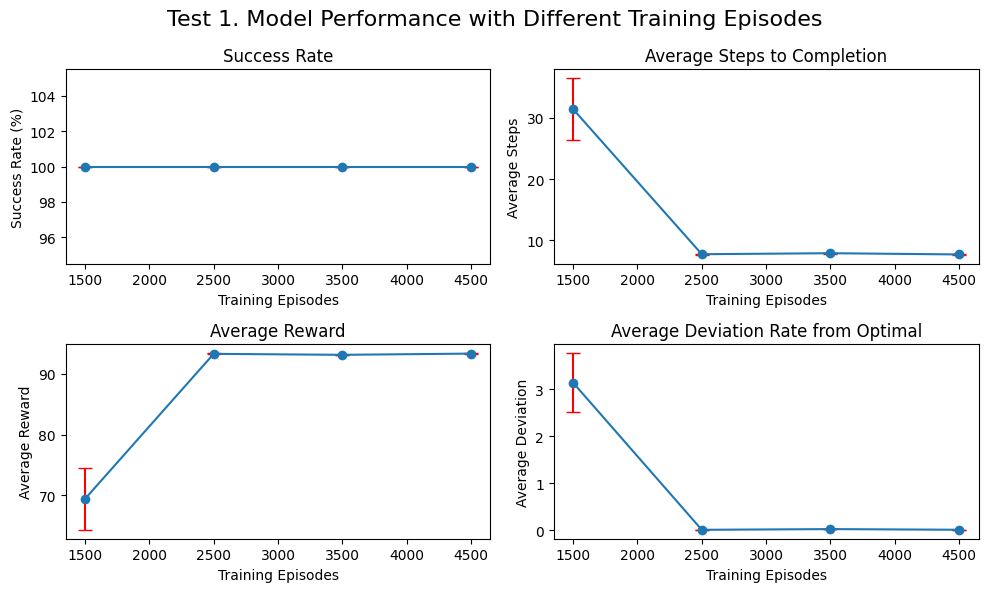

In [7]:
training_episodes_list = [1500, 2500, 3500, 4500]

test_episodes = 5
num_repeats = 5

# Set up the environment and agent actions
env = GridWorld(size=5)
actions = ['north', 'south', 'west', 'east']

# Dictionary to store results
results = {
    'training_episodes': [],
    'success_rate_mean': [],
    'success_rate_std': [],
    'average_steps_mean': [],
    'average_steps_std': [],
    'average_reward_mean': [],
    'average_reward_std': [],
    'average_deviation_rate_mean': [],
    'average_deviation_rate_std': []
}

# Run the experiment for different training episodes
for training_episodes in training_episodes_list:
    success_rates = []
    average_steps = []
    average_rewards = []
    average_deviations = []
    
    # Repeat the experiment for each training episode
    for _ in range(num_repeats):
        agent = QLearningAgent(actions)  # Reinitialise the agent for each training run
        train_agent(agent, env, training_episodes)
        metrics = test_agent(agent, env, episodes=test_episodes, step_verbose=False)
        # print(metrics)
        
        # Store individual test results
        success_rates.append(metrics['success_rate'])
        average_steps.append(metrics['average_steps'])
        average_rewards.append(metrics['average_reward'])
        average_deviations.append(metrics['average_deviation_rate'])
    
    # Store mean and standard deviation of results
    results['training_episodes'].append(training_episodes)
    results['success_rate_mean'].append(np.mean(success_rates))
    results['success_rate_std'].append(np.std(success_rates))
    results['average_steps_mean'].append(np.mean(average_steps))
    results['average_steps_std'].append(np.std(average_steps))
    results['average_reward_mean'].append(np.mean(average_rewards))
    results['average_reward_std'].append(np.std(average_rewards))
    results['average_deviation_rate_mean'].append(np.mean(average_deviations))
    results['average_deviation_rate_std'].append(np.std(average_deviations))

# Plotting results with error bars
plt.figure(figsize=(10, 6))
plt.suptitle('Test 1. Model Performance with Different Training Episodes', fontsize=16)

plt.subplot(2, 2, 1)
plt.errorbar(results['training_episodes'], results['success_rate_mean'], 
             yerr=np.array(results['success_rate_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Success Rate')
plt.xlabel('Training Episodes')
plt.ylabel('Success Rate (%)')

plt.subplot(2, 2, 2)
plt.errorbar(results['training_episodes'], results['average_steps_mean'], 
             yerr=np.array(results['average_steps_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Steps to Completion')
plt.xlabel('Training Episodes')
plt.ylabel('Average Steps')

plt.subplot(2, 2, 3)
plt.errorbar(results['training_episodes'], results['average_reward_mean'], 
             yerr=np.array(results['average_reward_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Reward')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward')

plt.subplot(2, 2, 4)
plt.errorbar(results['training_episodes'], results['average_deviation_rate_mean'], 
             yerr=np.array(results['average_deviation_rate_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Deviation Rate from Optimal')
plt.xlabel('Training Episodes')
plt.ylabel('Average Deviation')

plt.tight_layout()
plt.show()

Based on the test results, we can observe that as the number of training episodes increases, the model's Average Steps and Average Deviation Rate from Optimal consistently decrease, while the Average Reward steadily increases. This clearly demonstrates that the capability of the agent we designed improves with more training and approaches optimal performance. It can be seen that after approximately 3000 training episodes, the model's performance is already very close to optimal performance.

### **Test 2: Evaluating the performance of a model trained extensively across all initial states**
In the second test, we selected a model trained with 50000 episodes and evaluated its performance across all possible initial states. Specifically, we traversed all possible combinations of the agent's initial position and the item's position, measuring the model's performance in these scenarios.

#### **Code implementation**
To cover all possible initial states, we traversed each possible agent starting position and item position in a 5x5 grid and conducted multiple tests for each state. We recorded the success rate, average steps, average reward, and deviation rate from the optimal strategy, and the corresponding means and standard deviations are provided. It is worth pointing out that we exclude cases where the initial item position is the same as the initial agent position, and the initial item position is the same as the target location according to the assumptions.

#### **Capability assessment**
The purpose of this test is to evaluate whether the model, after extensive training, can perform well across all initial states. This is crucial for assessing the model's generalisation ability: whether it can successfully complete the task and achieve high rewards regardless of the initial conditions.


In [8]:
# Training parameters
training_episodes = 50000  # Number of training episodes, adjust as needed
test_episodes = 5 # Number of test episodes per configuration
num_repeats = 5  # Number of repeats per initial configuration

# Grid size
grid_size = 5

# Set up the environment and agent actions
env = GridWorld(size=grid_size)
actions = ['north', 'south', 'west', 'east']

# Initialise the agent and train
agent = QLearningAgent(actions)
train_agent(agent, env, training_episodes)

# Initialise dictionaries to store results
results = {
    'initial_states': [],
    'success_rate_mean': [],
    'success_rate_std': [],
    'average_steps_mean': [],
    'average_steps_std': [],
    'average_reward_mean': [],
    'average_reward_std': [],
    'average_deviation_rate_mean': [],
    'average_deviation_rate_std': []
}

# Iterate over all possible initial states (agent's start position and item's position)
for start_x in range(grid_size):
    for start_y in range(grid_size):
        for item_x in range(grid_size):
            for item_y in range(grid_size):
                success_rates = []
                average_steps = []
                average_rewards = []
                average_deviations = []

                initial_agent_pos = (start_x, start_y)
                initial_item_pos = (item_x, item_y)
                if initial_agent_pos == initial_item_pos:
                    continue
                if initial_agent_pos == env.target_location or initial_item_pos == env.target_location:
                    continue
                    
                # Repeat the test multiple times for each initial state
                for _ in range(num_repeats):
              
                    env = GridWorld(size=5, initial_agent_location= initial_agent_pos, initial_item_location= initial_item_pos, given_location = True )
                    metrics = test_agent(agent, env, episodes=test_episodes ,step_verbose=False)
                    
                    # Store individual test results
                    success_rates.append(metrics['success_rate'])
                    average_steps.append(metrics['average_steps'])
                    average_rewards.append(metrics['average_reward'])
                    average_deviations.append(metrics['average_deviation_rate'])
                
                # Store the mean and standard deviation of results

                results['success_rate_mean'].append(np.mean(success_rates))
                results['success_rate_std'].append(np.std(success_rates))
                results['average_steps_mean'].append(np.mean(average_steps))
                results['average_steps_std'].append(np.std(average_steps))
                results['average_reward_mean'].append(np.mean(average_rewards))
                results['average_reward_std'].append(np.std(average_rewards))
                results['average_deviation_rate_mean'].append(np.mean(average_deviations))
                results['average_deviation_rate_std'].append(np.std(average_deviations))

print(f"\n--- Final Summary over {num_repeats} Repeats of {test_episodes} Test Episodes ---")
print(f"success_rate: {np.mean(results['success_rate_mean']).round(2)} +/- {np.mean(results['success_rate_std']).round(2)}")
print(f"average_steps: {np.mean(results['average_steps_mean']).round(2)} +/- {np.mean(results['average_steps_std']).round(2)}")
print(f"average_reward: {np.mean(results['average_reward_mean']).round(2)} +/- {np.mean(results['average_reward_std']).round(2)}")
print(f"average_deviation_rate: {np.mean(results['average_deviation_rate_mean']).round(2)} +/- {np.mean(results['average_deviation_rate_std']).round(2)}")


--- Final Summary over 5 Repeats of 5 Test Episodes ---
success_rate: 100.0 +/- 0.0
average_steps: 7.54 +/- 0.94
average_reward: 93.42 +/- 0.96
average_deviation_rate: 0.01 +/- 0.02


It can be observed that after 50,000 episodes of training, the model performs well on average across various randomised initial conditions, achieving Success Rate of 100, low Average Steps, high Average Reward and very marginal Average Deviation Rate from Optimal.

***

### 6. Visualisation

The visualisation phase is implemented using the `matplotlib` library with the `TkAgg` backend, allowing for interactive and animated representations of the agent's behaviour in the grid world environment. This visualisation aims to show the performance of agents with different levels of training, assess their generalizability, and visually present the learning progress.

##### **Key components**

1. **Environment initialisation**:

The `env.reset()` function initialises the environment for each new episode, randomly setting the initial positions of the agent and item, preparing for a new simulation. It also establishes initial values for `state`, `done`, `episode_steps`, and `episode_reward`.

2. **Initial setup**:

Initial agent, item and target positions are printed, which provides context for the observer and serves as a benchmark for evaluating the agent's performance. 

3. **Visualisation setup**:

Functions like `ListedColormap()`, `plt.subplots()`, `ax.set_xticks()`, `ax.set_yticks()`, and `ax.grid()` are used to create and configure the figure object. Custom color maps and grid lines are set up to enhance visual clarity. The legend explains different grid states:

- Letter `A` with Green backgroun: Agent
- Letter `I` with Red background: Item
- Letter `T` with Gray background: Target location
- Text `A+I` with Cyan background: Agent carrying the item
- Text `A at T (No I)` with Magenta backgroun: Agent at target location without the item
- Text `A+I at T` with Orange background: Agent at target location with the item

4. **Animation function**:

The internal function `animate(i)` updates each frame of the visualisation. It calls `agent.choose_action(state)` and `env.step(action)` to show the agent's real-time decision-making process. It uses `ax.imshow()` to update the grid state and `ax.text()` to add annotations for different elements (agent, item, target). The function employs complex conditional logic to update grid states, reflecting different scenarios (e.g., agent carrying item, reaching target). It also prints detailed step information for in-depth analysis.

5. **Animation creation and display**:

The visualisation process is implemented using `FuncAnimation()` to create an animated representation of the agent's behavior. This animation is displayed using `plt.show()`. To ensure the visualisation remains manageable and informative, we use a maximum step limit `(max_steps=25)`, which serves three crucial purposes:

- It prevents the visualisation from running indefinitely if the agent is stuck in a loop.
- It simulates real-world constraints where tasks often have time or resource limitations.
- It provides a clear metric for improvement: as training progresses, the agent should complete the task within this limit more consistently.

**Two possible scenarios:**<br>

1. Task Not Completed (Failure Case):

If the maximum step limit is reached without task completion:
A `red` text annotation appears on the plot: "Failed to complete within `max_steps` step limit!"

2. Task Completed Successfully:

A `blue` text annotation is added to the plot: "Successfully completed the task with deviation from the optimal path by `deviation` step(s)!"

After each visulisation, comprehensive summary is printed, detailing:

- Number of steps taken
- Optimal step count
- Total reward accumulated
- Deviation from the optimal path

In [17]:
# Function to visualise one episode using the trained agent
def visualise_episode(agent, env, cumulative_episodes, interval=500, max_steps=25):
    # Reset the environment to start a new episode
    state = env.reset()
    done = False
    episode_steps = 0
    episode_reward = 0

    # Capture initial positions for printing
    initial_agent_location = state[0]
    initial_item_location = state[1]
    drop_off_location = env.target_location

    # Calculate theoretical shortest path or optimal steps
    optimal_steps_to_item = manhattan_distance(initial_agent_location, initial_item_location)
    optimal_steps_to_target = manhattan_distance(initial_item_location, drop_off_location)
    optimal_steps = optimal_steps_to_item + optimal_steps_to_target
    
    # Print the initial locations and episode information
    print(f"Initial Agent Location: {initial_agent_location}")
    print(f"Initial Item Location (A): {initial_item_location}")
    print(f"Drop-Off Location (B): {drop_off_location}")

    # Define a custom colormap
    # 0 - white (grid face), 1 - green (agent), 2 - red (item), 3 - gray (target), 4 - cyan (agent with item),
    # 5 - megenta (agent at the target without item), 6 - orange (agent with item at the target)
    cmap = ListedColormap(['white', 'green', 'red', 'gray', 'cyan', 'magenta', 'orange'])

    # Create the figure for visualisation
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xticks(np.arange(-0.5, env.size, 1))
    ax.set_yticks(np.arange(-0.5, env.size, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, color='black')  # Set grid lines to black
    ax.set_aspect('equal')

    # Set the background color to white
    ax.set_facecolor('white')

    # Add a title to the figure
    fig.suptitle(f'Grid World - Trained {cumulative_episodes} Episodes', fontsize=16)

    # Define the legend patches
    legend_patches = [
        mpatches.Patch(color='green', label='A - Agent'),
        mpatches.Patch(color='red', label='I - Item'),
        mpatches.Patch(color='gray', label='T - Target'),
        mpatches.Patch(color='cyan', label='A+I'),
        mpatches.Patch(color='magenta', label='A at T (No I)'),
        mpatches.Patch(color='orange', label='A+I at T'),
    ]

    # Animate the grid world for each step in the episode
    def animate(i):
        # Access the nonlocal variables to update them
        nonlocal state, episode_steps, done, episode_reward

        # Display the initial state before starting the episode
        if i == 0:
            agent_pos, item_pos, has_item = state

            grid = np.zeros((env.size, env.size))
            grid[agent_pos] = 1
            grid[item_pos] = 2
            grid[env.target_location] = 3

            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Annotate the grid with labels but no color changes
            for (j, i), label in np.ndenumerate(grid):
                if label == 1: # Agent location only
                    ax.text(i, j, 'A', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2: # Item location only
                    ax.text(i, j, 'I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3: # Target location only
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
            
            # Reapply the legend after clearing
            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

            return

        # Continue the episode if the task is not finished
        if not done:
            # Select the action and perform the step in the environment
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            episode_steps += 1
            episode_reward += reward
            state = next_state

            # Print the step details
            print(f"Step {episode_steps}: Action = {action}, Reward = {reward}, New State = {next_state}")

            # Create the grid to visualise
            grid = np.zeros((env.size, env.size))
            agent_pos, item_pos, has_item = next_state

            # Update the grid colors based on the current state
            if not has_item and agent_pos != env.target_location:
                grid[agent_pos] = 1
                grid[item_pos] = 2
                grid[env.target_location] = 3
            elif not has_item and agent_pos == env.target_location:
                grid[item_pos] = 2
                grid[env.target_location] = 5
            elif has_item and agent_pos != env.target_location:
                grid[agent_pos] = 4
                grid[env.target_location] = 3
            elif has_item and agent_pos == env.target_location:
                grid[env.target_location] = 6

            ax.clear()
            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Reapply grid lines and labels after clearing
            ax.set_xticks(np.arange(-0.5, env.size, 1))
            ax.set_yticks(np.arange(-0.5, env.size, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(True, color='black')  # Set grid lines to black
            ax.set_facecolor('white')  # Set background color to white

            # Annotate the grid with labels but no color changes
            for (j, i), label in np.ndenumerate(grid):
                if label == 1: # Agent location only
                    ax.text(i, j, 'A', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2: # Item location only
                    ax.text(i, j, 'I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3: # Target location only
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 4: # Agent location with item
                    ax.text(i, j, 'A+I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 5: # Target location with agent but without item
                    ax.text(i, j, 'A at T (No I)', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 6: # Target location with agent and item
                    ax.text(i, j, 'A+I at T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

            # Reapply the legend after clearing
            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

        # Stop the animation if the task is finished or the maximum steps are reached
        if done or episode_steps == max_steps:  
            deviation = episode_steps - optimal_steps
            if episode_steps == max_steps:
                print(f"*** After {cumulative_episodes} episodes of training, agent did not complete the task within {max_steps} steps.\n")
                # Annotate the "Failed" case on the plot
                ax.text(0.5, 0.5, f'Failed to complete within {max_steps} step limit !', 
                        ha='center', va='center', transform=ax.transAxes, 
                        fontsize=20, color='red', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))
            elif done:
                # Print the summary of the episode
                # Annotate the "Successful" case on the plot
                ax.text(0.5, 0.5, f'Successfully completed the task with\n deviation from the optimal path by {deviation} step(s) !'.format(episode_steps),
                        ha='center', va='center', transform=ax.transAxes, 
                        fontsize=20, color='blue', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))
                print(f"*** After {cumulative_episodes} episodes of training, agent completed the task.")
                print(f"Summary: Steps = {episode_steps} (Optimal Steps = {optimal_steps}), Total Reward = {episode_reward}, Deviation from Optimal: {deviation}\n")

            anim.event_source.stop()  # Stop the animation when done
            plt.draw()  # Force a draw of the current figure to ensure the last frame is rendered

            plt.pause(2)  # Short pause to ensure the rendering occurs
            plt.close(fig)  # Automatically close the figure window

    # Create the animation
    anim = FuncAnimation(fig, animate, interval=interval, frames=100) 

    plt.show()


**Examples of effects of different training episodes**

We use random initialisations for each test to evaluate the agent's ability to generalize. By randomly setting the initial positions of the agent and item for each visualisation, we ensure that the agent's performance is tested across various scenarios, not just those it encountered during training. This approach helps assess whether the agent has learned general strategies or merely memorized specific paths.

Progressive improvement with increased training:

As the number of training episodes increases, we observe a clear progression in the agent's performance:

- Exploratory stage (~ 100 episodes):

The agent is in the initial phase, exploring the environment with minimal learned behavior. The agent often fails to complete the task within the maximum step limit (25 steps). Movements appear random or inefficient, indicating insufficient learning.

- Adaptive stage (~ 500 episodes):

The agent begins to adapt to the environment, showing early signs of learning but with inconsistent performance.  It might complete simpler configurations but fail in more complex scenarios.

- Proficient stage (~ 1000 episodes):

The agent is now more proficient, often completing tasks, though not always optimally. It shows more purposeful movements, suggesting improved learning.

- Optimising stage (~ 2500 episodes):

The agent is refining its strategies, consistently completing tasks with greater efficiency and fewer errors. Deviations from the optimal steps are smaller and less frequent.<br>

- Mastery stage (~ 5000 episodes):

The agent demonstrates mastery, achieving tasks with high efficiency and minimal deviations from the optimal steps. It efficiently navigates to the item and then to the target location, demonstrating well-developed strategies. The performance across random initialisations is consistently high, indicating good generalisability.

This visualisation approach demonstrates the gradual improvement in the agent's performance across a wider range of training episodes. It highlights the agent's ability to generalise learned strategies to unseen situations, demonstrating the progression from failing to complete the task, to completing it sub-optimally, and finally to near-optimal completion across random scenarios. This comprehensive view allows us to observe the improvements at each stage of training, providing insights into the learning dynamics of the Q-learning algorithm in this grid world environment.

In [19]:
# Visualise trained agent at different training levels

# training progression list, e.g. first train for 100 episodes, then an additional 400 episodes
# with a total of 500 episodes, then an addtional 500 episodes with a total of 1000 episodes, and so on
# This is equivalent to test an agent at different training levels of 100, 500, 1000, 2500, and 5000 episodes.
episodes_progression_list = [100, 400, 500, 1500, 2500]

# Initialise the environment and agent
env = GridWorld(size=5)
actions = ['north', 'south', 'west', 'east']
agent = QLearningAgent(actions)
cumulative_episodes = 0

for episode in episodes_progression_list:
    cumulative_episodes += episode
    train_agent(agent, env, episode)
    print(f"--- After {cumulative_episodes} Training Episodes Test Visualisation and Summary---")
    
    visualise_episode(agent, env, cumulative_episodes)

--- After 100 Training Episodes Test Visualisation and Summary---
Initial Agent Location: (4, 1)
Initial Item Location (A): (3, 4)
Drop-Off Location (B): (4, 4)
Step 1: Action = north, Reward = -1, New State = ((3, 1), (3, 4), False)
Step 2: Action = north, Reward = -1, New State = ((2, 1), (3, 4), False)
Step 3: Action = east, Reward = -1, New State = ((2, 2), (3, 4), False)
Step 4: Action = south, Reward = -1, New State = ((3, 2), (3, 4), False)
Step 5: Action = north, Reward = -1, New State = ((2, 2), (3, 4), False)
Step 6: Action = east, Reward = -1, New State = ((2, 3), (3, 4), False)
Step 7: Action = south, Reward = -1, New State = ((3, 3), (3, 4), False)
Step 8: Action = south, Reward = -1, New State = ((4, 3), (3, 4), False)
Step 9: Action = west, Reward = -1, New State = ((4, 2), (3, 4), False)
Step 10: Action = north, Reward = -1, New State = ((3, 2), (3, 4), False)
Step 11: Action = west, Reward = -1, New State = ((3, 1), (3, 4), False)
Step 12: Action = south, Reward = -1, 

***

### 7. Conclusion and Limitations

In this project, we successfully implemented a tabular Q-learning agent to navigate a grid world environment. The agent’s task was to locate a randomly positioned item and deliver it to a fixed target location, optimising the number of steps taken. Through iterative development and testing, we crafted a reward structure that effectively guided the agent’s learning process, allowing it to generalize across various initial conditions. The results demonstrate that our agent efficiently learned to perform the task, achieving high performance across different scenarios. The visualisations provided clearly illustrated the agent’s learning progression, further validating our approach.

While our implementation effectively accomplished the task, several limitations were identified. The primary limitation is the scalability of tabular Q-learning. As the grid size increases, the state-action space expands exponentially, making it computationally intensive to manage the Q-table. This limitation also constrains the agent’s ability to learn in more complex environments that require finer granularity in state representation.

Additionally, the agent’s learning efficiency is highly dependent on the reward structure and hyperparameters such as the learning rate and exploration strategy. Optimising these parameters requires extensive experimentation, which may not always be feasible in more complex environment settings.

Moreover, the fixed nature of the grid world and the simplicity of the task do not fully reflect the challenges encountered in real-world applications. Addressing dynamic environments, obstacles, and more sophisticated task objectives would require advanced techniques, such as deep learning-based function approximation, which are beyond the scope of tabular Q-learning.

Overall, this stage of the project laid a strong foundation for further exploration in reinforcement learning. The insights gained here will be invaluable as we transition to more complex environments and learning paradigms in subsequent stages. Our results underscore the potential of tabular Q-learning as a robust method for solving pathfinding and optimisation problems in grid-based environments, despite its limitations.

### 8. Acknowledgement

We utilised ChatGPT (OpenAI, 2024) to summarise the code and review the grammar in our work. The output was subsequently adjusted to better align with our writing style.

### 9. References

OpenAI. (2024). ChatGPT (Version 1.2024.227) [Large language model]. https://chatgpt.com/